# BC4 Pipeline

#### &rarr; Goal: Track savings realised by the Energy Conservation Measures (ECMs) undertaken by the ESCO on a daily/weekly/monthly basis (M&V)

#### &rarr; General process:

- Create a model of the electricity consumption using the data before the renovation happened (pre-retrofit).

- Get the "simulated" electricity consumption after the renovation of the building (post-retrofit).

- Calculate the difference between the two to estimate the savings.


#### &rarr; AI-toolbox usage: identification of a baseline model for the electricity consumption in the pre-retrofit period



### 0. Import initial libraries
Here we will use the sklearn extension for intel processors to speed up the training phase

In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import pandas_bokeh
import json

pandas_bokeh.output_notebook()
#pd.set_option('plotting.backend', 'pandas_bokeh')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Loading BokehJS ...

### 1. Read the harmonized time series in json format

#### - Define directories where the json and rdf files are located

In [2]:
from os import getcwd
from os.path import join

dataset_dir = join(getcwd(), "static_data")
ts_filename = join(dataset_dir, "timeseries.json")
rdf_filename = join(dataset_dir, "timeseries_metadata.ttl")



#### - Visualize fake RDF as a Graph

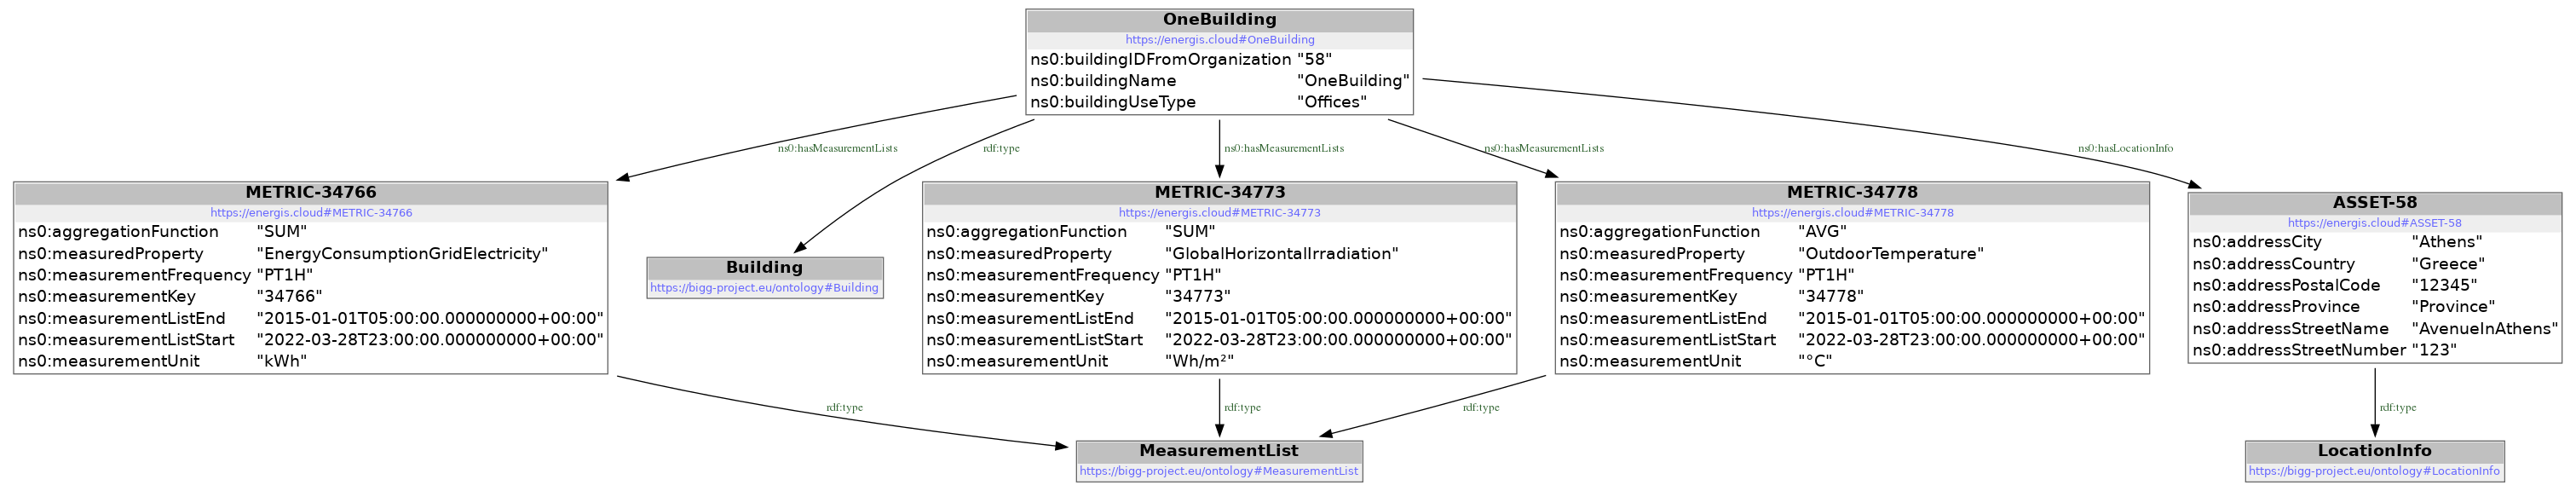

In [3]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from rdflib import Graph, Namespace, URIRef, Literal

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))
    
g = Graph()
g.parse(rdf_filename, format="ttl")
visualize(g)

#### - Convert the json loaded from file to a pandas dataframe and extract the name and aggregation functions of the time series from the rdf file

In [4]:
def get_aggregation(function: str) -> str:
        if function.lower() in ['avg', 'average']:
            return 'mean'
        else: 
            return function.lower()

def harmonized_dict_to_dataframe(data: dict, graph: Graph, ontology: str='https://bigg-project.eu/ontology#') -> (pd.DataFrame, dict):
    
    df_list = []
    agg_functions = {}
    namespace_ontology = Namespace(ontology)
    
    for name, time_series in data.items():
        measurement_list = graph.value(None, namespace_ontology['measurementKey'], Literal(name))
        if measurement_list is not None:
            measured_property = str(graph.value(measurement_list, namespace_ontology['measuredProperty'], None))
            agg_function = str(graph.value(measurement_list, namespace_ontology['aggregationFunction'], None))
            agg_functions[measured_property] = get_aggregation(agg_function)
        else:
            measured_property = name
        df_temp = pd.DataFrame.from_records(
                        time_series,
                        columns=["measurementStart", "value"]).rename(columns={"measurementStart": "timestamp", "value": measured_property})
        df_temp["timestamp"] = pd.to_datetime(
                    df_temp["timestamp"],
                    infer_datetime_format=True)
        df_temp.set_index('timestamp', inplace=True)
        df_list.append(df_temp)
        
    return pd.concat(df_list, axis=1), agg_functions


with open(ts_filename, 'r') as f:
    df, aggregations = harmonized_dict_to_dataframe(data=json.load(f), graph=g)
    
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2015-01-01 00:00:00+00:00,107.64,4.76,0.0
2015-01-01 01:00:00+00:00,105.24,4.37,0.0
2015-01-01 02:00:00+00:00,106.02,4.35,0.0
2015-01-01 03:00:00+00:00,106.68,4.31,0.0
2015-01-01 04:00:00+00:00,105.18,4.20,0.0
...,...,...,...
2016-01-31 19:00:00+00:00,96.06,11.46,0.0
2016-01-31 20:00:00+00:00,89.16,11.08,0.0
2016-01-31 21:00:00+00:00,86.58,10.68,0.0


In [5]:
target = "EnergyConsumptionGridElectricity"

### 2. Get high-level data description

#### - Get general statistics on the dataframe

In [6]:
df.describe()

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
count,9503.000000,9504.000000,9504.000000
mean,168.825049,17.210737,204.195867
std,103.647717,7.531746,285.612792
min,0.000000,1.200000,0.000000
25%,92.640000,11.280000,0.000000
50%,111.600000,16.380000,6.357200
75%,221.130000,23.110000,381.799525
max,527.640000,37.790000,1015.180000


#### - Print correlation matrix

In [7]:
df.corr()

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
EnergyConsumptionGridElectricity,1.000000,0.483842,0.594970
OutdoorTemperature,0.483842,1.000000,0.498177
GlobalHorizontalIrradiation,0.594970,0.498177,1.000000


#### - Plot the data as they are

In [8]:

df.plot_bokeh.line(
    x=df.index, 
    y=["EnergyConsumptionGridElectricity", "OutdoorTemperature", "GlobalHorizontalIrradiation"],
    figsize=(1200, 600),
    ylim=(0, 700),
    zooming=True,
    panning=True,
    rangetool=True
)

Column(id='1177', ...)

### 3. Clean up the data

#### - Check NaN per column

In [9]:
df.isna().sum(axis = 0)

EnergyConsumptionGridElectricity    1
OutdoorTemperature                  0
GlobalHorizontalIrradiation         0
dtype: int64

#### - Check duplicated values

In [10]:
df[df.index.duplicated(False)]

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,


#### - Remove duplicates and keep last

In [11]:
df = df[~df.index.duplicated(keep='last')]
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2015-01-01 00:00:00+00:00,107.64,4.76,0.0
2015-01-01 01:00:00+00:00,105.24,4.37,0.0
2015-01-01 02:00:00+00:00,106.02,4.35,0.0
2015-01-01 03:00:00+00:00,106.68,4.31,0.0
2015-01-01 04:00:00+00:00,105.18,4.20,0.0
...,...,...,...
2016-01-31 19:00:00+00:00,96.06,11.46,0.0
2016-01-31 20:00:00+00:00,89.16,11.08,0.0
2016-01-31 21:00:00+00:00,86.58,10.68,0.0


#### - Analyse frequencies of data grid with detect_time_step

Here we are lucky that the 3 series have the same frequency. The first is irregular, e.g. with gaps, while the other two are uniform.

In [12]:
df.to_csv("/home/rick/Scaricati/timeseries.csv")

In [13]:
from ai_toolbox.data_preparation import detect_time_step, align_time_grid
from pandas.tseries.frequencies import to_offset

list_freq = []
for column in df.columns.to_list():
    print("{}\n".format(detect_time_step(df[column])))
    list_freq.append(detect_time_step(df[column])[0])

('H',                  freq_count freqstr
timedelta                          
0 days 01:00:00        9501       H
0 days 02:00:00           1      2H)

('H', None)

('H', None)



#### - Align time grid if necessary

If there are different frequencies in the data grid, get the max time step for the alignment and use the aggregation functions extracted from the rdf. In our case it is not necessary to align the frequecies because all the series have hourly frequency but they could be misaligned.

In [14]:
if len(set(list_freq)) > 1:
    print("Data are not at the same frequency.")
else:
    print("All data are at the same frequency but could be misaligned.")

columns_resampled = []
max_freq = max(list_freq, key=to_offset)
df= df.resample(max_freq).agg(aggregations, skipna=False)

All data are at the same frequency but could be misaligned.


#### - Drop NaNs

In [15]:
df.dropna(inplace=True)

#### - Detect outliers for the training phase
Here we want to prepare the data for the training and remove only the most evident outliers.

In [16]:
from sklearn.cluster import DBSCAN

outliers = DBSCAN(min_samples=30, eps=30).fit_predict(df[[target]])
df= df.assign(outliers= df[target].where(outliers < 0))
df[~df.outliers.isna()]

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation,outliers
timestamp,,,,
2015-03-29 01:00:00+00:00,20.94,11.44,0.0000,20.94
2015-06-13 10:00:00+00:00,24.90,28.75,981.3607,24.90
2015-09-26 08:00:00+00:00,0.00,23.12,144.2925,0.00
2015-09-26 09:00:00+00:00,0.00,23.21,153.7192,0.00
2015-09-26 10:00:00+00:00,0.00,23.28,173.6412,0.00
2015-09-26 11:00:00+00:00,13.56,23.46,236.3181,13.56
2015-10-25 01:00:00+00:00,0.00,14.20,0.0000,0.00


#### - Plot the outliers and the series

In [17]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.models import  HoverTool

tools_to_show = 'hover,box_zoom,pan,save,reset,wheel_zoom'
cds = ColumnDataSource(df)
p = figure(x_axis_type="datetime", height=600, width=1200, tools=tools_to_show, title= "Electricity consumption outliers")
p.line(
    x='timestamp',
    y="EnergyConsumptionGridElectricity",
    source=cds,
    legend_label="EnergyConsumptionGridElectricity",
    color="#104ca2"
)
p.circle(
    x='timestamp',
    y="outliers",
    source=cds,
    legend_label="outliers",
    color="#4b875f",
    size=8

)
p.legend.click_policy="hide"
hover = p.select(dict(type=HoverTool))
hover.formatters={'@timestamp': 'datetime'}
hover.tooltips = [("consumption", "@EnergyConsumptionGridElectricity{int}"), ("outlier", "@outliers{int}"), ("date", "@timestamp{%F}")]
hover.mode = 'mouse'
show(p)

#### - Remove outliers and drop the column "outliers" used to create the plot

In [18]:
df = df[df.outliers.isna()]
df.drop(columns='outliers', inplace=True)
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2015-01-01 00:00:00+00:00,107.64,4.76,0.0
2015-01-01 01:00:00+00:00,105.24,4.37,0.0
2015-01-01 02:00:00+00:00,106.02,4.35,0.0
2015-01-01 03:00:00+00:00,106.68,4.31,0.0
2015-01-01 04:00:00+00:00,105.18,4.20,0.0
...,...,...,...
2016-01-31 19:00:00+00:00,96.06,11.46,0.0
2016-01-31 20:00:00+00:00,89.16,11.08,0.0
2016-01-31 21:00:00+00:00,86.58,10.68,0.0


### 4. Modeling

#### - Columns to be used as predictors (X data)
We remove only the y feature, the one that we want to predict based on the predictor features. Also, we will keep a slice of the dataset for out-of-sample predictions, i.e. we will use only the data of the 2015 for the model training.

In [19]:
predictors = [feature for feature in list(df.columns) if feature not in [target]]
sorted(predictors)

['GlobalHorizontalIrradiation', 'OutdoorTemperature']

In [20]:
X = df.loc["2015", predictors]
X

,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,
2015-01-01 00:00:00+00:00,4.76,0.0
2015-01-01 01:00:00+00:00,4.37,0.0
2015-01-01 02:00:00+00:00,4.35,0.0
2015-01-01 03:00:00+00:00,4.31,0.0
2015-01-01 04:00:00+00:00,4.20,0.0
...,...,...
2015-12-31 19:00:00+00:00,2.62,0.0
2015-12-31 20:00:00+00:00,2.62,0.0
2015-12-31 21:00:00+00:00,2.65,0.0


#### - Columns to be used as outcome variable
We also limit the time range of the outcome between the year 2015:2018 (2018 excluded).

In [21]:
y = df.loc["2015", target]
y

timestamp
2015-01-01 00:00:00+00:00    107.64
2015-01-01 01:00:00+00:00    105.24
2015-01-01 02:00:00+00:00    106.02
2015-01-01 03:00:00+00:00    106.68
2015-01-01 04:00:00+00:00    105.18
                              ...  
2015-12-31 19:00:00+00:00    135.12
2015-12-31 20:00:00+00:00    125.40
2015-12-31 21:00:00+00:00    111.60
2015-12-31 22:00:00+00:00    100.44
2015-12-31 23:00:00+00:00     98.58
Name: EnergyConsumptionGridElectricity, Length: 8753, dtype: float64

### - Check the output of the trasfomers used in the pipelines (for demo purposes)
In this section we want to check the results of the data transformations that will be executed in the Pipelines defined in our grid.

In [22]:
from ai_toolbox.data_transformation import CalendarComponentTransformer

components = ["weekday", "hour"]

CalendarComponentTransformer(components=components, encode=True).fit_transform(X)

,OutdoorTemperature,GlobalHorizontalIrradiation,weekday_sin,weekday_cos,hour_sin,hour_cos
timestamp,,,,,,
2015-01-01 00:00:00+00:00,4.76,0.0,0.433884,-0.900969,0.000000,1.000000
2015-01-01 01:00:00+00:00,4.37,0.0,0.433884,-0.900969,0.258819,0.965926
2015-01-01 02:00:00+00:00,4.35,0.0,0.433884,-0.900969,0.500000,0.866025
2015-01-01 03:00:00+00:00,4.31,0.0,0.433884,-0.900969,0.707107,0.707107
2015-01-01 04:00:00+00:00,4.20,0.0,0.433884,-0.900969,0.866025,0.500000
...,...,...,...,...,...,...
2015-12-31 19:00:00+00:00,2.62,0.0,0.433884,-0.900969,-0.965926,0.258819
2015-12-31 20:00:00+00:00,2.62,0.0,0.433884,-0.900969,-0.866025,0.500000
2015-12-31 21:00:00+00:00,2.65,0.0,0.433884,-0.900969,-0.707107,0.707107


#### - Fit transfomer to get holidays from X data
The holiday components are not added to the predictors in this phase but after using transformers in a Pipeline. Here, we just want to check that everything goes fine.

In [23]:
from ai_toolbox.data_transformation import HolidayTransformer

HolidayTransformer(country='GR').fit_transform(X)

,OutdoorTemperature,GlobalHorizontalIrradiation,holiday
timestamp,,,
2015-01-01 00:00:00+00:00,4.76,0.0,1
2015-01-01 01:00:00+00:00,4.37,0.0,1
2015-01-01 02:00:00+00:00,4.35,0.0,1
2015-01-01 03:00:00+00:00,4.31,0.0,1
2015-01-01 04:00:00+00:00,4.20,0.0,1
...,...,...,...
2015-12-31 19:00:00+00:00,2.62,0.0,0
2015-12-31 20:00:00+00:00,2.62,0.0,0
2015-12-31 21:00:00+00:00,2.65,0.0,0


In [24]:
from ai_toolbox.data_transformation import DegreeDaysTransformer, optimize_balance_point_temperature

hdd_bpt = optimize_balance_point_temperature(X["OutdoorTemperature"], y, "heating")
cdd_bpt = optimize_balance_point_temperature(X["OutdoorTemperature"], y, "cooling")
print("HDD bpt: {}, CDD bpt: {}".format(hdd_bpt, cdd_bpt))
base_temperature = {"HeatingDegreeDays": hdd_bpt[0], "CoolingDegreeDays": cdd_bpt[0]}
DegreeDaysTransformer(base_temperature=base_temperature).fit_transform(X, y)

HDD bpt: (17.0, -0.2938330840890066), CDD bpt: (20.0, -0.5470924409158714)


,OutdoorTemperature,GlobalHorizontalIrradiation,HeatingDegreeDays,CoolingDegreeDays
timestamp,,,,
2015-01-01 00:00:00+00:00,4.76,0.0,0.510000,0.0
2015-01-01 01:00:00+00:00,4.37,0.0,0.526250,0.0
2015-01-01 02:00:00+00:00,4.35,0.0,0.527083,0.0
2015-01-01 03:00:00+00:00,4.31,0.0,0.528750,0.0
2015-01-01 04:00:00+00:00,4.20,0.0,0.533333,0.0
...,...,...,...,...
2015-12-31 19:00:00+00:00,2.62,0.0,0.599167,0.0
2015-12-31 20:00:00+00:00,2.62,0.0,0.599167,0.0
2015-12-31 21:00:00+00:00,2.65,0.0,0.597917,0.0


In [25]:
from ai_toolbox.data_transformation import WeeklyProfileTransformer

WeeklyProfileTransformer().fit_transform(X, y)

,OutdoorTemperature,GlobalHorizontalIrradiation,EnergyConsumptionGridElectricity_weekly_profile
timestamp,,,
2015-01-01 00:00:00+00:00,4.76,0.0,97.14
2015-01-01 01:00:00+00:00,4.37,0.0,95.76
2015-01-01 02:00:00+00:00,4.35,0.0,95.52
2015-01-01 03:00:00+00:00,4.31,0.0,95.04
2015-01-01 04:00:00+00:00,4.20,0.0,105.72
...,...,...,...
2015-12-31 19:00:00+00:00,2.62,0.0,142.26
2015-12-31 20:00:00+00:00,2.62,0.0,120.84
2015-12-31 21:00:00+00:00,2.65,0.0,102.84


#### - Nested CV optimization framework
We want to find the best performing pipeline from the initial grid of pipelines and parameters using nested CV.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from ai_toolbox.data_transformation import ScalerTransformer
from ai_toolbox.data_modelling import identify_best_model

from math import sqrt, ceil
from time import time
import numpy as np

cv_splitter_outer = TimeSeriesSplit(n_splits=7)
cv_splitter_inner = TimeSeriesSplit(n_splits=5)
n_features = len(predictors) + len(components) + 1


grid = {
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('calendar', CalendarComponentTransformer(components=components, encode=False)), 
        ('model',  RandomForestRegressor())
    ]
    ):
    {
        'model__n_estimators': [10, 100],
        'model__max_features': np.linspace(ceil(sqrt(len(predictors))), len(predictors), 3, dtype=int)  
    },
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('scaler', ScalerTransformer(scaler=StandardScaler())),
        ('calendar', CalendarComponentTransformer(components=components, encode=True)), 
        ('model', SVR(cache_size=2000))
    ]
    ):
    {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['auto', 'scale']
    },
    Pipeline([
        ('holidays', HolidayTransformer(country='GR')),
        ('dd', DegreeDaysTransformer(base_temperature=base_temperature)),
        ('weekly_profile', WeeklyProfileTransformer()),
        ('poly', PolynomialFeatures(include_bias=False)),
        ('model', Lasso())
    ]):     
    {
        'poly__degree': list(range(1, 3)),
        'model__alpha': [0.1, 1, 10]
    }
}  

start_time = time()
results = identify_best_model(
    X_data=X,
    y_data=y,
    model_families_parameter_grid=grid,
    cv_inner=cv_splitter_inner,
    cv_outer=cv_splitter_outer,
    scoring=['r2', 'mean_bias_error', 'neg_root_mean_squared_error', 'normalized_mean_bias_error', 'cv_rmse'],
    compare_with='r2'
)

print("Best model: {}\n".format(results[0]))
print("Best parameters: {}\n".format(results[1]))
print("Mean score: {}\n".format(results[2]))
print("Std score: {}\n".format(results[3]))
print("Evaluation results: {}\n".format(results[5]))

print("Time to identify best model: {} seconds.".format(time()-start_time))

#### - Check the scores of the different model families

In [ ]:
pd.DataFrame.from_dict(results[5])

#### - Check the cross validation results of the best model retrained on the entire dataset

In [ ]:
pd.DataFrame.from_dict(results[4])

In [ ]:
best_model = results[0]
best_model

#### - Check specific outputs based on the best pipeline
Linear models can be represented simply by a mathematical expression while other models cannot. Ensemble models like RandomForest can provide feature importances as an output. 

In [ ]:
from sklearn.ensemble import BaseEnsemble
from sklearn.linear_model._base import LinearModel

pipeline_model = best_model.steps[-1][1]
if isinstance(pipeline_model, BaseEnsemble):
    for k, v in zip(pipeline_model.feature_names_in_, pipeline_model.feature_importances_):
        print(k, v)
elif isinstance(pipeline_model, LinearModel):
    coefficients = pipeline_model.coef_
    intercept = pipeline_model.intercept_
    powers = best_model.steps[-2][1].powers_
    feature_powers = best_model.steps[-2][1].get_feature_names_out()
    print("Coefficients: {}".format(coefficients))
    print("Intercept: {}".format(intercept))
    print("Powers: {}".format(powers))
    print("Feature names: {}".format(feature_powers))
    
    formula = "y = "
    for c, p in zip(coefficients, feature_powers):
        if c:
            formula+= "{:+} {} ".format(round(c, 3), p)

    formula += "{:+}".format(round(intercept, 3))
    print("Formula: {}".format(formula))
else: 
    print("The model is not linear nor an ensemble. Nothing to show.")

#### - Add the y_predicted to the dataframe for visualization purposes

In [ ]:
df["y_pred"] = best_model.predict(df[predictors])

#### - Plot Actual Consumption and predictions
We want to visualize how the predictions will look like

In [ ]:
df.plot_bokeh.line(
    title = "Predictions vs Actual Consumptions",
    x=df.index, 
    y=["EnergyConsumptionGridElectricity", "y_pred"],
    figsize=(1200, 600),
    ylim=(0, 1000),
    zooming=True,
    panning=True,
    rangetool=True
)

### 6. Model serialization
We will serialize the best performing pipeline and store it on the disk.

In [ ]:
from ai_toolbox.data_modelling import serialize_model

model_filename = "best_pipeline_bc4"

model_full_path = serialize_model(best_model, join(dataset_dir, model_filename), 'cloudpickle')
model_full_path